<a href="https://colab.research.google.com/github/AzucenaMV/CapstoneProject/blob/master/3_Modeling_Lasso%2BTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression,Ridge, Lasso

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# read data
df_all = pd.read_csv("all_variables.csv")
#df_all = pd.read_csv('https://raw.githubusercontent.com/AzucenaMV/CapstoneProject/master/data/final/all_variables.csv') # saved from DataProcessing_Stationary.ipynb
df_all = df_all.set_index('date').dropna()

In [0]:
# get X, Y
def get_variables(df_all, target_col, n_shifts):  
  target_col_shift = target_col+'t+'+str(n_shifts)
  df = df_all.copy(deep=True)
  df[target_col_shift] = df[target_col].shift(-1*n_shifts)
  df = df.dropna()
  y = df[[target_col_shift]]
  features = list(df.columns[~df.columns.str.contains('TARGET')])
  X = df[features]
  return X, y

def calculate_vif_(df_all, thresh=5.0):
  """stepwise selection of features using vif"""
  df = df_all.copy(deep=True)
  features = list(df.columns[~df.columns.str.contains('TARGET')])
  targets = list(df.columns[df.columns.str.contains('TARGET')])
  X = df[features]
  variables = list(range(X.shape[1]))
  dropped = True
  while dropped:
      dropped = False
      vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
              for ix in range(X.iloc[:, variables].shape[1])]

      maxloc = vif.index(max(vif))
      if max(vif) > thresh:
          print('Dropping \'' + X.iloc[:, variables].columns[maxloc], ', VIF:', vif[maxloc].round(1))
          del variables[maxloc]
          dropped = True
  X_filtered = X.iloc[:, variables]
  print('\nVIF of all variables are below', thresh)

  print('\nNumber of features left:', len(X_filtered.columns))
  
  df_filtered = df[list(X_filtered.columns)+targets]
  return df_filtered

In [0]:
df_filtered = calculate_vif_(df_all)

Dropping 'industrialProdOilGasExtraction_OIL , VIF: 22.9
Dropping 'globalWTICrude_OIL , VIF: 7.0

VIF of all variables are below 5.0

Number of features left: 33


In [0]:
split = '2020-03-01'
df_test = df_filtered[df_filtered.index >= split]
df_train = df_filtered[df_filtered.index <= split]

In [0]:
targets = df_all.columns[df_all.columns.str.contains('_RELATIVE') & ~df_all.columns.str.contains('market')]

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
results = {}
lasso_coefs = {}
best_cols = {}
best_alpha = {}
max_lags = 3
t = 14
alphas = np.arange(0.05,0.0,-.01)

for target in targets:
  print('=======',target, '=======')
  results[target] = {}
  lasso_coefs[target] = {}
  for lag in range(1,max_lags+1):
    X,y = get_variables(df_train, target_col = target, n_shifts = lag)
    X_train, X_test = X[:-1*t], X[-1*t:]
    y_train, y_test = y[:-1*t], y[-1*t:]
    # standardization for X
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Lasso regression
    lasso = Lasso()
    grid = GridSearchCV(estimator = lasso, param_grid=dict(alpha=alphas), scoring= "neg_mean_squared_error")
    grid.fit(X_train,y_train)
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)

    print('\nLag=',lag, 'best model coefficients:')
    print('Train MSE=', grid.score(X_train,y_train))
    print("Best alpha: ",grid.best_estimator_.alpha)
    print("Accuracy: ", )
    betas = pd.DataFrame(index=list(X.columns[grid.best_estimator_.coef_.nonzero()]), data=grid.best_estimator_.coef_[grid.best_estimator_.coef_.nonzero()]).sort_values(0)
    print(betas)
    best_cols[y.columns[0]] = X.columns[grid.best_estimator_.coef_.nonzero()]
    best_alpha[y.columns[0]] = grid.best_estimator_.alpha
    lasso_coefs[target][lag] = grid.best_estimator_.coef_
    
    outcome = df_train[[target]].rename(columns={target:'true'})
    outcome['predict'] =np.r_[[0]*lag, y_train_pred.flatten(), y_test_pred.flatten()]
    outcome['set'] = ['none']*lag+['train']*len(y_train) + ['test']*len(y_test)
    outcome = outcome.reset_index()
    results[target][lag] = outcome

======= specialty_TARGET_RELATIVE =======

Lag= 1 best model coefficients:
Train MSE= -484.8275528963992
Best alpha:  0.05
                                            0
pPScheduledPassenger_AIR            -7.506031
globalBrentCrude_OIL                -7.174784
industrialProdMachinery_OIL         -6.441425
industrialProdChem_CHEM             -4.820780
moneyStockM2_ECON                   -4.817096
pPIChemicalManufac_CHEM             -4.700533
industrialProdDrilling_OIL          -4.050032
interbankRates90day_ECON            -3.624718
airTransportation_AIR               -2.242666
pPIOilGasMachinery_OIL              -2.063831
consumerPriceIndex_ECON             -1.802216
cPIFuelOil_OIL                      -1.747858
advanceRetailSales_ECON             -1.097322
pPCarRental_OTHERS                  -1.009378
realDisposableInc_ECON              -0.510883
industrialProductionChemProd_CHEM   -0.452003
unemploymentRate_ECON                0.050045
exportPriceIndPharma_OTHERS          0.222288
pPI

Visualizations

In [0]:
def viz_format(date):
  year, month = date[:4], date[5:7]
  if month == '01':
    return date[:7]
  else:
    return ''

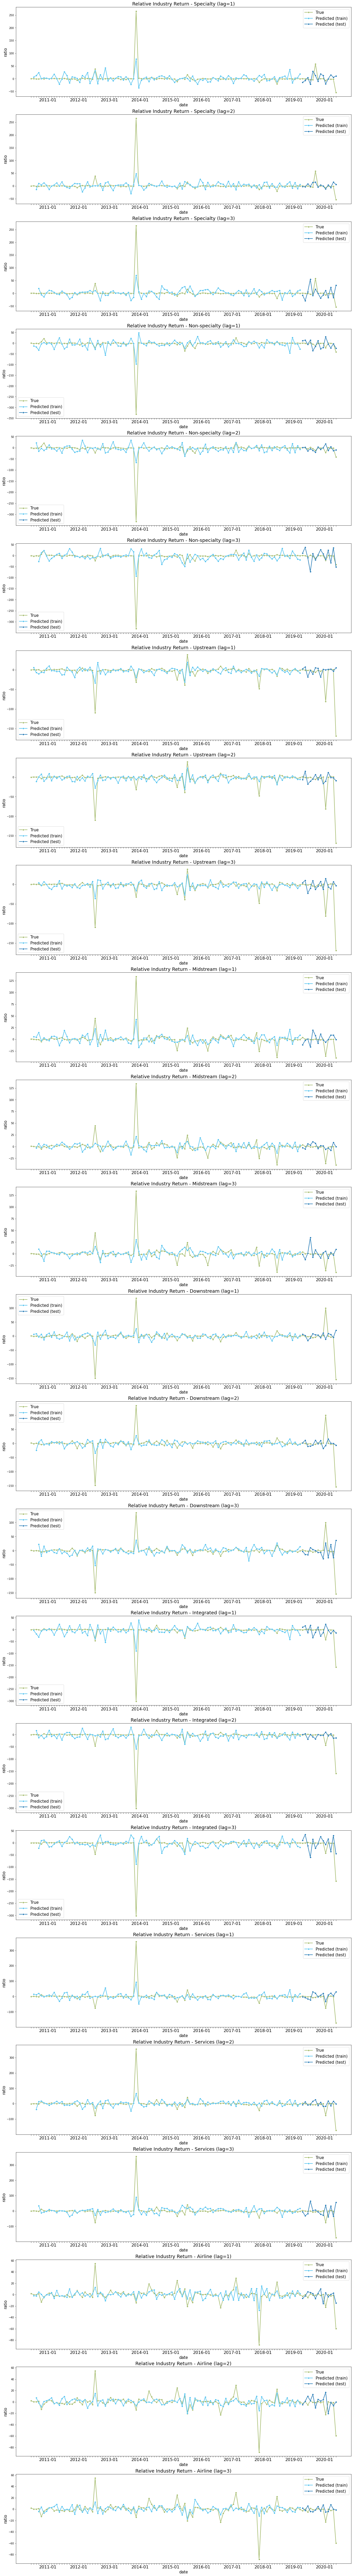

In [0]:
lags = [1,2,3]
fig, ax = plt.subplots(len(lags)*len(targets), 1, figsize=(23,180))
i = 0

for ind in targets:
  for lag in lags:
    outcome = results[ind][lag]
    sns.lineplot(data=outcome, y='true', x='date', marker='o', label='True', color='#a2b969', linewidth=2, ax=ax[i])
    sns.lineplot(data=outcome[outcome['set']=='train'], y='predict', x='date', marker='o', label='Predicted (train)', color='#4cc1ef', linewidth=2, ax=ax[i])
    sns.lineplot(data=outcome[outcome['set']=='test'], y='predict', x='date', marker='o', label='Predicted (test)', linewidth=2, ax=ax[i])

    ax[i].legend(prop={'size': 15})
    ttl = ind[:-16]
    ax[i].set_title('Relative Industry Return - {} (lag={})'.format(ttl[0].upper()+ttl[1:],lag), fontsize=18)
    ax[i].set_ylabel('ratio', fontsize=15)
    ax[i].set_xlabel('date', fontsize=15)

    labels = outcome['date'].apply(viz_format)
    ticks = [i for i in range(len(labels))]
    ax[i].set_xticklabels(labels=labels, horizontalalignment="right", fontsize=16)
    #ax[i].set_yticklabels(fontsize=16)
    i += 1

plt.savefig('plots.png')

In [0]:
$plt.savefig('plots.png')

<Figure size 432x288 with 0 Axes>

Decision Tree


In [0]:
from sklearn.metrics import make_scorer
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

results = {}
max_lags = 3
t = 14
depths = np.arange(4, 10)
num_leafs = [1, 2, 5, 7, 10]

for target in targets:
  print('=======',target, '=======')
  results[target] = {}
  for lag in range(1,max_lags+1):
    X,y = get_variables(df_train, target_col = target, n_shifts = lag)
    X_train, X_test = X[:-1*t], X[-1*t:]
    y_train, y_test = y[:-1*t], y[-1*t:]

    regr = DecisionTreeRegressor()
    param_grid = [{'max_depth':depths,
              'min_samples_leaf':num_leafs}]

    gs = GridSearchCV(estimator=regr, 
                      param_grid=param_grid,
                      scoring=mse_scorer)
    
    gs = gs.fit(X_train, y_train)
    model = gs.best_estimator_
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print('\nLag=',lag)
    print(gs.best_params_)
    print("Test MSE: {}".format(root_mean_squared_error(y_test,y_test_pred)))
    print("Important Features: \n{}".format("\n".join(X_train.columns[features])))
    
    outcome = df_train[[target]].rename(columns={target:'true'})
    outcome['predict'] =np.r_[[0]*lag, y_train_pred.flatten(), y_test_pred.flatten()]
    outcome['set'] = ['none']*lag+['train']*len(y_train) + ['test']*len(y_test)
    outcome = outcome.reset_index()
    results[target][lag] = outcome

======= specialty_TARGET_RELATIVE =======

Lag= 1
{'max_depth': 6, 'min_samples_leaf': 2}
Test MSE: 21.278907951094432
Important Features: 
globalBrentCrude_OIL
industrialProdDrilling_OIL
pPIOilGasMachinery_OIL
industrialProdChem_CHEM
employeesOilGasExtraction_OIL
exportPriceIndPharma_OTHERS
pPIOilGasExtraction_OIL
pPIOilGasMachinery_OIL
pPIOilGasMachinery_OIL
globalBrentCrude_OIL
pPAirlinePassengerServices_AIR
airTransportation_AIR

Lag= 2
{'max_depth': 5, 'min_samples_leaf': 10}
Test MSE: 19.7851920286478
Important Features: 
globalBrentCrude_OIL
industrialProdDrilling_OIL
pPIOilGasMachinery_OIL
industrialProdChem_CHEM
employeesOilGasExtraction_OIL
exportPriceIndPharma_OTHERS
pPIOilGasExtraction_OIL
pPIOilGasMachinery_OIL
pPIOilGasMachinery_OIL
globalBrentCrude_OIL
pPAirlinePassengerServices_AIR
airTransportation_AIR

Lag= 3
{'max_depth': 6, 'min_samples_leaf': 1}
Test MSE: 21.248673233048258
Important Features: 
globalBrentCrude_OIL
industrialProdDrilling_OIL
pPIOilGasMachinery_OIL


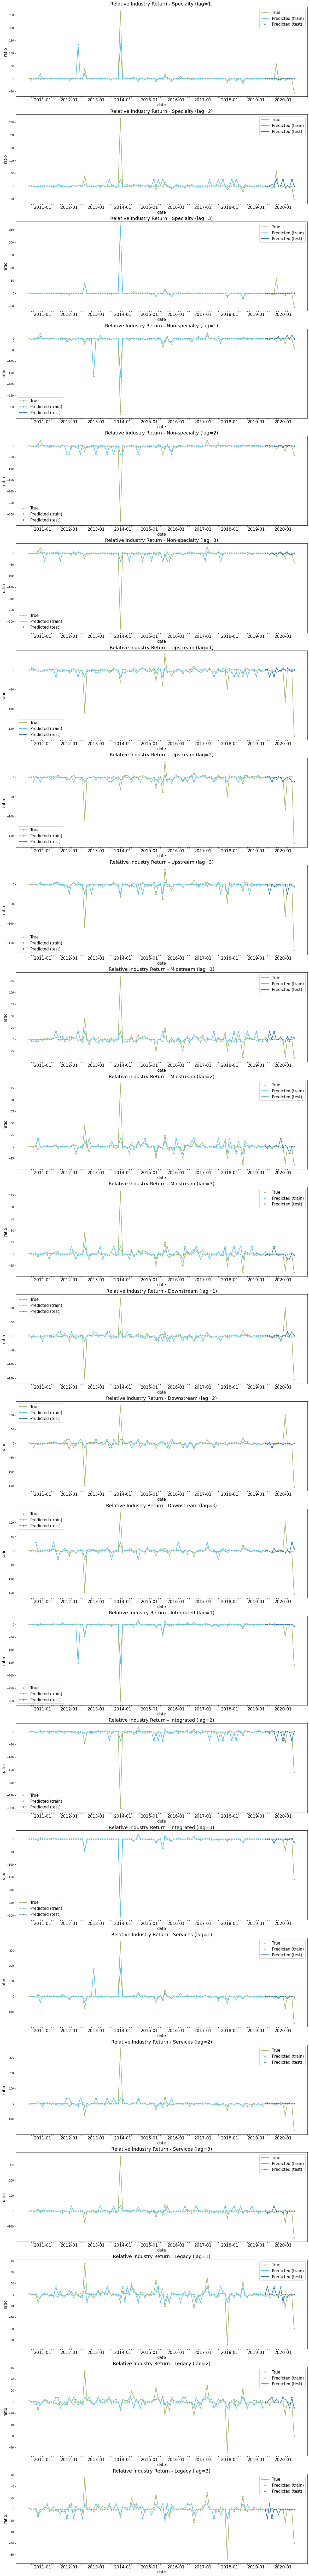

In [0]:
lags = [1,2,3]
fig, ax = plt.subplots(len(lags)*len(targets), 1, figsize=(20,180))
i = 0

for ind in targets:
  for lag in lags:
    outcome = results[ind][lag]
    sns.lineplot(data=outcome, y='true', x='date', marker='o', label='True', color='#a2b969', linewidth=2, ax=ax[i])
    sns.lineplot(data=outcome[outcome['set']=='train'], y='predict', x='date', marker='o', label='Predicted (train)', color='#4cc1ef', linewidth=2, ax=ax[i])
    sns.lineplot(data=outcome[outcome['set']=='test'], y='predict', x='date', marker='o', label='Predicted (test)', linewidth=2, ax=ax[i])

    ax[i].legend(prop={'size': 15})
    ttl = ind[:-16]
    ax[i].set_title('Relative Industry Return - {} (lag={})'.format(ttl[0].upper()+ttl[1:],lag), fontsize=18)
    ax[i].set_ylabel('ratio', fontsize=15)
    ax[i].set_xlabel('date', fontsize=15)

    labels = outcome['date'].apply(viz_format)
    ticks = [i for i in range(len(labels))]
    ax[i].set_xticklabels(labels=labels, horizontalalignment="right", fontsize=16)
    #ax[i].set_yticklabels(fontsize=16)
    i += 1